# Classification: Data Modeling

In [2]:
import pickle

import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from os.path import exists

from scipy.stats import uniform
from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn import svm
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score

pd.set_option('display.max_colwidth', 100)

In [3]:
target = 'tweets'

# The first line for upsampled data, the second for the original data
supervised_up_target_path = f'../dataset/processed/supervised_{target}_upsampled.csv'
supervised_down_target_path = f'../dataset/processed/supervised_{target}_downsampled.csv'
supervised_target_path = f'../dataset/processed/supervised_{target}.csv'

model_path = '../dataset/model/sental_model.pkl'
model_best_params_path = '../dataset/model/svm_best_params.pkl'
vectorizer_path = '../dataset/model/sental_vectorizer.pkl'

In [4]:
# df = pd.read_csv(supervised_target_path, delimiter=';')
df = pd.read_csv(supervised_up_target_path, delimiter=';')
# df = pd.read_csv(supervised_down_target_path, delimiter=';')

df

,date,content,text_clean,case_folding,tokens,review,polarity,sentiment,label
0,2022-09-04 23:59:55+00:00,@soeyoto1 @msaid_didu Bukti kalau Pemerintahan Pak @jokowi tidak pro rakyat. Tapi pro oligarki. ...,Bukti kalau Pemerintahan Pak tidak pro rakyat Tapi pro oligarki Vivo BBMnya lebih murah dari Pem...,bukti kalau pemerintahan pak tidak pro rakyat tapi pro oligarki vivo bbmnya lebih murah dari pem...,"['bukti', 'kalau', 'perintah', 'tidak', 'pro', 'rakyat', 'pro', 'oligarki', 'vivo', 'bmnya', 'le...",bukti kalau perintah tidak pro rakyat pro oligarki vivo bmnya lebih murah dari perintah naik aga...,-11,0,Negative
1,2022-09-04 23:59:38+00:00,"@KompasTV Mentri esdm, trus patokanmu apa? Kantong pertamina udah jebol karna banyak dikorupsi, ...",Mentri esdm trus patokanmu apa Kantong pertamina udah jebol karna banyak dikorupsi imbasnya raky...,mentri esdm trus patokanmu apa kantong pertamina udah jebol karna banyak dikorupsi imbasnya raky...,"['menteri', 'esdm', 'patok', 'apa', 'kantong', 'pertamina', 'sudah', 'jebol', 'karena', 'banyak'...",menteri esdm patok apa kantong pertamina sudah jebol karena banyak korupsi imbas rakyat yang men...,-20,0,Negative
2,2022-09-04 23:58:55+00:00,@Tan_Mar3M Kalau Vivo bisaberani bertahan dengan harga lama bagaimana pula nasib Pertamina ? 🤔,Kalau Vivo bisaberani bertahan dengan harga lama bagaimana pula nasib Pertamina,kalau vivo bisaberani bertahan dengan harga lama bagaimana pula nasib pertamina,"['kalau', 'vivo', 'berani', 'tahan', 'harga', 'lama', 'nasib', 'pertamina']",kalau vivo berani tahan harga lama nasib pertamina,-3,0,Negative
3,2022-09-04 23:57:45+00:00,Menteri BUMN Erick Thohir menegaskan persiapan Indonesia soal transisi energi baru terbarukan. S...,Menteri BUMNErick Thohirmenegaskan persiapan Indonesia soal transisi energi baru terbarukan Sala...,menteri bumnerick thohirmenegaskan persiapan indonesia soal transisi energi baru terbarukan sala...,"['menteri', 'bumnerick', 'thohirmenegaskan', 'siap', 'indonesia', 'soal', 'transisi', 'energi', ...",menteri bumnerick thohirmenegaskan siap indonesia soal transisi energi salah satu upaya lewat ke...,-5,0,Negative
4,2022-09-04 23:57:38+00:00,"Itu kata orang pertamina si wkwkwk, dan hampir setiap hari aku test Sirkulasi franchise Pertamin...",Itu kata orang pertamina wkwkwk dan hampir setiap hari aku test Sirkulasi franchise Pertamina ya...,itu kata orang pertamina wkwkwk dan hampir setiap hari aku test sirkulasi franchise pertamina ya...,"['itu', 'kata', 'orang', 'pertamina', 'aku', 'uji', 'sirkulasi', 'franchise', 'pertamina', 'pert...",itu kata orang pertamina aku uji sirkulasi franchise pertamina pertashop yang henti penjualanya,-10,0,Negative
...,...,...,...,...,...,...,...,...,...
9289,2022-09-03 21:24:06+00:00,"@MurtadhaOne1 Harga minyak dunia lagi turun, harga bbm pertamina malah naik....hebatnya dimana??...",Harga minyak dunia lagi turun harga bbm pertamina malah naikhebatnya dimana,harga minyak dunia lagi turun harga bbm pertamina malah naikhebatnya dimana,"['harga', 'minyak', 'dunia', 'lagi', 'turun', 'harga', 'bm', 'pertamina', 'naikhebatnya']",harga minyak dunia lagi turun harga bm pertamina naikhebatnya,0,1,Positive
9290,2022-09-04 07:19:23+00:00,@PebriansyahW @JawaraOnline @AnthonyBudiawan Ngab Harga BBM di SPBU VIVO lbh mura ini sdh sejak ...,Ngab Harga BBM SPBU VIVO lbh mura ini sdh sejak tahun Dan Mekosaurus LBP sdh ingin mengetahui me...,ngab harga bbm spbu vivo lbh mura ini sdh sejak tahun dan mekosaurus lbp sdh ingin mengetahui me...,"['ngab', 'harga', 'bm', 'spbu', 'vivo', 'lebih', 'mura', 'sudah', 'mekosaurus', 'lbp', 'sudah', ...",ngab harga bm spbu vivo lebih mura sudah mekosaurus lbp sudah pertamina jual bm lebih mahal dari...,10,1,Positive
9291,2022-09-03 14:22:14+00:00,"@Jphms @DeltaDesignSDA @jokowi @pertamina @ogud_belitong Main ke Bali,biar tahu mahalnya Harga K...",Main Balibiar tahu mahalnya Harga Kamar Hotel,main balibiar tahu mahalnya harga kamar hotel,"['main', 'balibiar', 'tahu', 'mahal', 'harga', 'kamar

## Section 1: Term weighting with TF-IDF & Data Splitting

In [5]:
def term_weighting_tfidf(X_train, X_test):
	vectorizer = TfidfVectorizer(use_idf=True, min_df = 5, max_df = 0.8, sublinear_tf = True)

	X_train_tfidf = vectorizer.fit_transform(X_train)
	X_test_tfidf = vectorizer.transform(X_test)
	return X_train_tfidf, X_test_tfidf, vectorizer

def save_vectorizer(model_vectorizer):
  with open(vectorizer_path, 'wb') as f:
    pickle.dump(model_vectorizer, f)

In [6]:
def split_data(test_size=0.2):
		X = df['review']
		y = df['sentiment']
		return train_test_split(X, y, test_size=test_size, random_state=687)

def split_stratified_data(test_size=0.2):
		X = df['review']
		y = df['sentiment']
		return train_test_split(X, y, test_size=test_size, random_state=687, stratify=y)

## Section 2: Classification with SVM

In [7]:
def save_svm_best_param(best_params):
  with open(model_best_params_path, 'wb') as f:
    pickle.dump(best_params, f)

def save_model(model):
  with open(model_path, 'wb') as f:
    pickle.dump(model, f)

def random_best_search_param(X_train_tfidf, y_train):
  param_grid = {'C': uniform(loc=0, scale=4),
              'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
              'gamma': uniform(loc=0, scale=0.1)}
  model = svm.SVC()
  grid_search = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=100, cv=5, n_jobs=-1, random_state=0, verbose=1, scoring='accuracy', return_train_score=True, error_score=0.0, refit=True, pre_dispatch='2*n_jobs')
  grid_search.fit(X_train_tfidf, y_train)

  save_svm_best_param(grid_search.best_params_)

  print("Best parameters: ", grid_search.best_params_)
  print("Best score: ", grid_search.best_score_)
  
  return grid_search.best_params_

def load_svm_best_param():
	try:
		with open(model_best_params_path, 'rb') as f:
			return pickle.load(f)
	except FileNotFoundError:
		return None

def load_svm_model(X_train_tfidf, y_train):
    model = None

    if exists(model_path):
      with open(model_path, 'rb') as f:
        model = pickle.load(f)
    else:
      best_params = load_svm_best_param()
      if best_params is None:
        best_params = random_best_search_param(X_train_tfidf, y_train)
        print("Loaded best parameters from grid search")
      else:
        print("Use parameters: ", best_params)
        print("Loaded best parameters from file")
      
      # add probability=True to get probabilities
      model = svm.SVC(**best_params, decision_function_shape='ovr', probability=True)

    print('Parameters: ', model.get_params())
    return model

def model_predict(model, y, y_pred):
	acc = accuracy_score(y, y_pred)
	precision = precision_score(y, y_pred, average='binary')
	recall = recall_score(y, y_pred, average='binary')
	f1 = f1_score(y, y_pred, average='binary')
	matrix = confusion_matrix(y, y_pred)

	print("Accuracy:", acc)
	print("Precision:", precision)
	print("Recall:", recall)
	print("F1-Score:", f1)
	print('Confusion Matrix :')
	print(matrix)
	print('\n Report : ') 
	print(classification_report(y, y_pred))

	f, ax = plt.subplots(figsize=(8,5))
	sns.heatmap(matrix, annot=True, fmt=".0f", ax=ax)
	plt.xlabel("Predicted")
	plt.ylabel("Actual")
	plt.show()

## Section 3: Experiments

### Section 3.1: SVM with TF-IDF (Non-Stratified Data)

In [8]:
X_train, X_test, y_train, y_test = split_data()
X_train_tfidf, X_test_tfidf, vectorizer = term_weighting_tfidf(X_train, X_test)

print('Train data count: ', len(X_train))
print('Train data positive count: ', len(y_train[y_train == 1]))
print('Train data negative count: ', len(y_train[y_train == 0]))
print('Test data count: ', len(X_test))
print('Test data positive count: ', len(y_test[y_test == 1]))
print('Test data negative count: ', len(y_test[y_test == 0]))
print()
print(df.shape)

svm_model = load_svm_model(X_train_tfidf, y_train)
svm_model.fit(X_train_tfidf, y_train)

model_score = svm_model.score(X_test_tfidf, y_test)
print("Model score: ", model_score)

Train data count:  7435
Train data positive count:  3723
Train data negative count:  3712
Test data count:  1859
Test data positive count:  924
Test data negative count:  935

(9294, 9)
Parameters:  {'C': 2.491384382186678, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 0.06736596308357894, 'kernel': 'linear', 'max_iter': -1, 'probability': True, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}
Model score:  0.9279182356105433


#### Section 3.1.1: Evaluation

Accuracy: 0.9279182356105433
Precision: 0.9022403258655805
Recall: 0.9588744588744589
F1-Score: 0.9296956977964322
Confusion Matrix :
[[839  96]
 [ 38 886]]

 Report : 
              precision    recall  f1-score   support

           0       0.96      0.90      0.93       935
           1       0.90      0.96      0.93       924

    accuracy                           0.93      1859
   macro avg       0.93      0.93      0.93      1859
weighted avg       0.93      0.93      0.93      1859



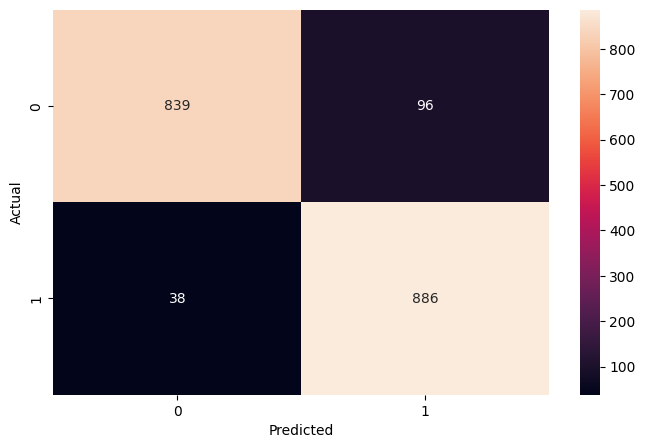

Accuracy: 0.9765971755211836
Precision: 0.9663600525624179
Recall: 0.9876443728176202
F1-Score: 0.9768862911795961
Confusion Matrix :
[[3584  128]
 [  46 3677]]

 Report : 
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      3712
           1       0.97      0.99      0.98      3723

    accuracy                           0.98      7435
   macro avg       0.98      0.98      0.98      7435
weighted avg       0.98      0.98      0.98      7435



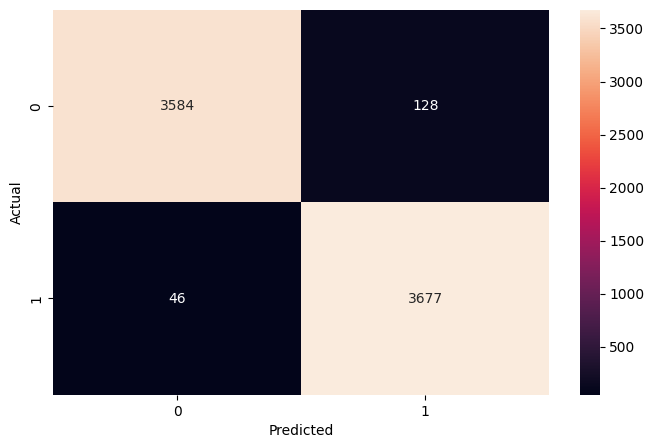

In [9]:
y_pred_train = svm_model.predict(X_train_tfidf)
y_pred_test = svm_model.predict(X_test_tfidf)

model_predict(svm_model, y_test, y_pred_test)
model_predict(svm_model, y_train, y_pred_train)

### Section 3.2: SVM with TF-IDF (Stratified Data)

In [10]:
X_train, X_test, y_train, y_test = split_stratified_data()
X_train_tfidf, X_test_tfidf, vectorizer = term_weighting_tfidf(X_train, X_test)

print('Train data count: ', len(X_train))
print('Train data positive count: ', len(y_train[y_train == 1]))
print('Train data negative count: ', len(y_train[y_train == 0]))
print('Test data count: ', len(X_test))
print('Test data positive count: ', len(y_test[y_test == 1]))
print('Test data negative count: ', len(y_test[y_test == 0]))
print()
print(df.shape)

svm_model = load_svm_model(X_train_tfidf, y_train)
svm_model.fit(X_train_tfidf, y_train)

model_score = svm_model.score(X_test_tfidf, y_test)
print("Model score: ", model_score)

Train data count:  7435
Train data positive count:  3718
Train data negative count:  3717
Test data count:  1859
Test data positive count:  929
Test data negative count:  930

(9294, 9)
Parameters:  {'C': 2.491384382186678, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 0.06736596308357894, 'kernel': 'linear', 'max_iter': -1, 'probability': True, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}
Model score:  0.9316837009144702


#### Section 3.2.1: Evaluation

Accuracy: 0.9316837009144702
Precision: 0.9066937119675457
Recall: 0.9623250807319699
F1-Score: 0.9336814621409922
Confusion Matrix :
[[838  92]
 [ 35 894]]

 Report : 
              precision    recall  f1-score   support

           0       0.96      0.90      0.93       930
           1       0.91      0.96      0.93       929

    accuracy                           0.93      1859
   macro avg       0.93      0.93      0.93      1859
weighted avg       0.93      0.93      0.93      1859



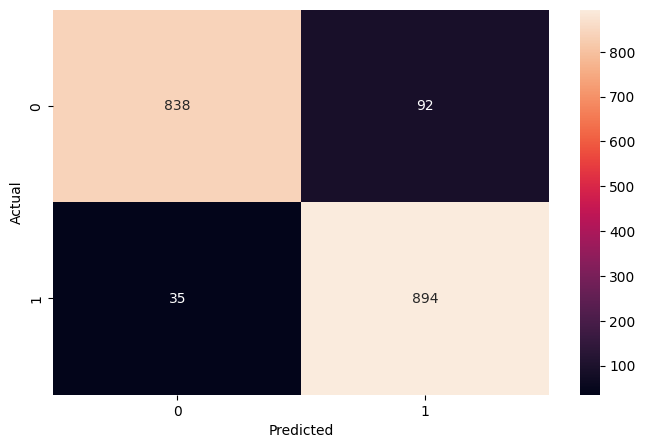

Accuracy: 0.9780766644250168
Precision: 0.9676400947119179
Recall: 0.9892415277030662
F1-Score: 0.9783215853171964
Confusion Matrix :
[[3594  123]
 [  40 3678]]

 Report : 
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      3717
           1       0.97      0.99      0.98      3718

    accuracy                           0.98      7435
   macro avg       0.98      0.98      0.98      7435
weighted avg       0.98      0.98      0.98      7435



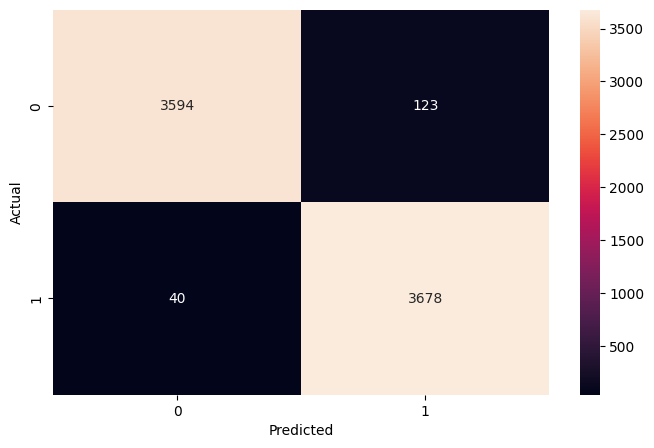

In [11]:
y_pred_train = svm_model.predict(X_train_tfidf)
y_pred_test = svm_model.predict(X_test_tfidf)

model_predict(svm_model, y_test, y_pred_test)
model_predict(svm_model, y_train, y_pred_train)

## Section 4: Test & Conclusion

In [12]:
%run "../shared.py"

Term dictionary: 13396 loaded
Normalization list: 1044
Indonesian stopwords: 540
English stopwords: 179
Custom stopwords: 17
Total stopwords: 736


In [13]:
# Results from prediction sentiment on data test

result_test = pd.DataFrame(data=zip(X_test, y_pred_test), columns=['review', 'code'])

polarity_decode = {0 : 'Negative', 1 : 'Positive'}
result_test['sentiment'] = result_test['code'].map(polarity_decode)

pd.set_option('max_colwidth', 300)
result_test.sample(10)

,review,code,sentiment
190,yeay pasti pasok bm aman direktur utama pertamina awas langsung dari comand center perlu khawatir ygy,1,Positive
668,itu kompensasi bm trilyun salah satu yang kasih kompensasi itu pertamax bengkak siapa suruh pertamina jual rugi pertamax sampai minta tutup pakai kompensasi,0,Negative
1008,pertamina tidak rugi kalau keuntunganya pakai perintah lain operasi migas baca dana kampanye dl,0,Negative
451,kalau pakai logika harga bm pertamina harga duniasubsidi lebih murah,1,Positive
480,sudah naik kendari spbu poasia kendari kemaren beli pertamax,1,Positive
1750,pertamina beli bm pertalite pakai mypertamina meski harga pertalite resmi naik liter,1,Positive
768,mungkin pertamina mau naik omzet vivo,1,Positive
1371,kalau anda ngak beli produk pertamina kagak ngapa ngak ngaruh buat pertamina,0,Negative
1508,umum magang pertamina guys makasih work,1,Positive
1007,syukur pertalite naik kasih bonus buat pegawai pertamina bodoh komisaris jangan lupa gas listrik siap sesuai harga rakyat kuat,1,Positive


In [14]:
sample_text = 'Kami Mendukung Keputusan PemeRintah untUk menAIkkan HARga BBM'
sample_text = preprocessing(sample_text)

sample_text_tfidf = vectorizer.transform([sample_text])
polarity = svm_model.predict(sample_text_tfidf)

sentiment = polarity_decode[polarity[0]]

print(f"Sampel text: {sample_text}")
print(f"Sentiment: {sentiment}")

Sampel text: dukung putus perintah naik harga bm
Sentiment: Positive


In [15]:
sample_text = 'saya benci pemerintah'
sample_text = preprocessing(sample_text)

sample_text_tfidf = vectorizer.transform([sample_text])
polarity = svm_model.predict(sample_text_tfidf)
# polarity_proba = svm_model.predict_proba(sample_text_tfidf)

sentiment = polarity_decode[polarity[0]]

print(f"Sampel text: {sample_text}")
print(f"Sentiment: {sentiment}")

Sampel text: saya benci perintah
Sentiment: Negative


In [16]:
save_model(svm_model)
save_vectorizer(vectorizer)

## Section 5: Visualizations

Indonesian stopwords: 758
English stopwords: 179
Custom stopwords: 17
Total stopwords: 954


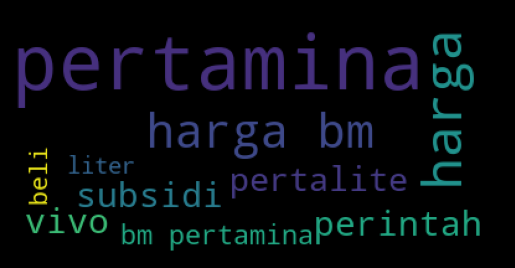

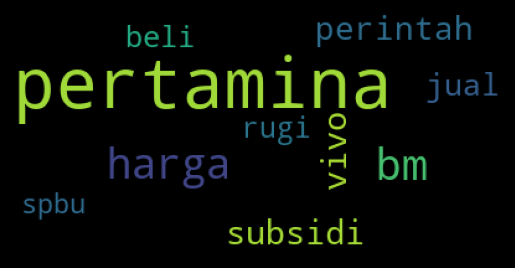

In [29]:
df_wordcloud = pd.DataFrame(data=zip(X_test, y_pred_test), columns=['review', 'code'])

# remove stopword
stopwords = load_stopwords_list(exclude_lexicon=False)
df_wordcloud['review'] = df_wordcloud['review'].apply(lambda x: ' '.join([word for word in x.split() if word not in stopwords]))

#word cloud for positive review words
pos_words = ' '.join(list(df_wordcloud[df_wordcloud['code'] == 1]['review']))
pos_wordcloud = WordCloud(max_words=10,background_color='black').generate(pos_words)
plt.figure(facecolor = 'k')
plt.imshow(pos_wordcloud)
plt.axis('off')
plt.show()

#word cloud for negative review words
neg_words = ' '.join(list(df_wordcloud[df_wordcloud['code'] == 0]['review']))
neg_wordcloud = WordCloud(max_words=10,background_color='black').generate(neg_words)
plt.figure(facecolor = 'k')
plt.imshow(neg_wordcloud)
plt.axis('off')
plt.show()

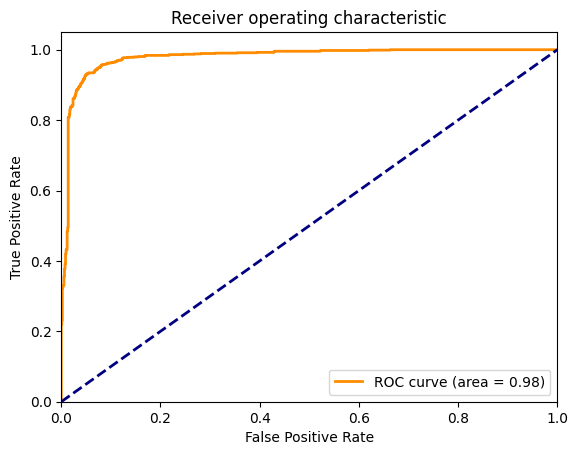

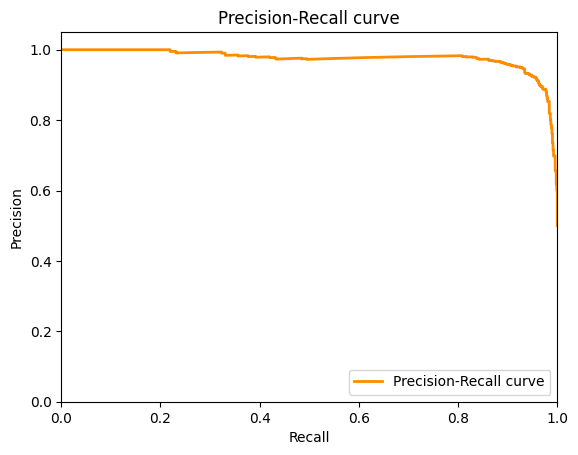

In [18]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve

# Compute ROC curve and ROC area for each class
fpr, tpr, thresholds = roc_curve(y_test, svm_model.predict_proba(X_test_tfidf)[:,1], pos_label=1)
roc_auc = auc(fpr, tpr)

# Compute precision-recall
precision, recall, thresholds = precision_recall_curve(y_test, svm_model.predict_proba(X_test_tfidf)[:,1], pos_label=1)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange',lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

# Plot precision-recall curve
plt.figure()
plt.plot(recall, precision, color='darkorange', lw=2, label='Precision-Recall curve')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc="lower right")
plt.show()